# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

Tutorials to use OpenAI DRL to trade multiple stocks in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog uses FinRL to reproduce the paper: Practical Deep Reinforcement Learning Approach for Stock Trading, Workshop on Challenges and Opportunities for AI in Financial Services, NeurIPS 2018.
* Check out medium blog for detailed explanations: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-multiple-stock-trading-7b00763b7530
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)   
* [RLlib Section](#7)            

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-p931xbn3
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-p931xbn3
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-gacg8spm/pyfolio_4e2a8f8b021d4443a889fb4d4663cd62
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-gacg8spm/pyfolio_4e2a8f8b021d4443a889fb4d4663cd62
     |████████████████████████████████| 172 kB 28.9 MB/s 
     |████████████████████████████████| 49.6 MB 6.3 kB/s 
     |████████████████████████████████| 1.8 MB 37.1 MB/s 
     |████████████████████████████████| 124 kB 61.1 MB/s 
     |████████████████████████████████| 108 kB 65.7 MB/s 
     |████████████████████████████████| 40 kB 4.8 MB/s 
     |████████████████████████████████| 2.0 MB 59.0 MB/s 
     |████████████████████████████████| 153 kB 52.9 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
     |██████████


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.neo_finrl.env_stock_trading.env_stocktrading_np import StockTradingEnv as StockTradingEnv_numpy
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.drl_agents.rllib.models import DRLAgent as DRLAgent_rllib
from finrl.neo_finrl.data_processor import DataProcessor


from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
import ray
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [4]:
# from config.py start_date is a string
config.START_DATE

'2009-01-01'

In [5]:
# from config.py end_date is a string
config.END_DATE

'2021-01-01'

In [6]:
print(config.DOW_30_TICKER)

['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [7]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-07-06',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [8]:
df.shape

(94410, 8)

In [9]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.782837,746015200,AAPL,4
1,2009-01-02,18.570000,19.520000,18.400000,15.657365,10955700,AXP,4
2,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4
3,2009-01-02,44.910000,46.980000,44.709999,32.655109,7117200,CAT,4
4,2009-01-02,16.410000,17.000000,16.250000,12.505757,40980600,CSCO,4


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [10]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3146, 8)
Successfully added vix
Successfully added turbulence index


In [11]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [12]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.782837,746015200.0,4.0,0.0,100.0,66.666667,100.0,39.189999,0.0
1,2009-01-02,AXP,18.570000,19.520000,18.400000,15.657365,10955700.0,4.0,0.0,100.0,66.666667,100.0,39.189999,0.0
2,2009-01-02,BA,42.799999,45.560001,42.779999,33.941101,7010200.0,4.0,0.0,100.0,66.666667,100.0,39.189999,0.0
3,2009-01-02,CAT,44.910000,46.980000,44.709999,32.655109,7117200.0,4.0,0.0,100.0,66.666667,100.0,39.189999,0.0
4,2009-01-02,CSCO,16.410000,17.000000,16.250000,12.505757,40980600.0,4.0,0.0,100.0,66.666667,100.0,39.189999,0.0
5,2009-01-02,CVX,74.230003,77.300003,73.580002,46.178165,13695900.0,4.0,0.0,100.0,66.666667,100.0,39.189999,0.0
6,2009-01-02,DD,21.605234,22.060680,20.993229,15.219840,13251037.0,4.0,0.0,100.0,66.666667,100.0,39.189999,0.0
7,2009-01-02,DIS,22.760000,24.030001,22.500000,20.597496,9796600.0,4.0,0.0,100.0,66.666667,100.0,39.189999,0.0
8,2009-01-02,GS,84.019997,87.620003,82.190002,71.965530,14088500.0,4.0,0.0,100.0,66.666667,100.0,39.189999,0.0
9,2009-01-02,HD,23.070000,24.190001,22.959999,17.615519,14902500.0,4.0,0.0,100.0,66.666667,100.0,39.189999,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2018-12-31
## Trade data split: 2019-01-01 to 2020-09-30

In [13]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-07-06')
print(len(train))
print(len(trade))

86790
7590


In [14]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
2892,2020-06-30,V,191.490005,193.750000,190.160004,191.749405,9040100.0,1.0,1.054351,53.021033,-51.499717,2.013358,30.43,12.486623
2892,2020-06-30,VZ,54.919998,55.290001,54.360001,52.217354,17414800.0,1.0,-0.453081,48.097041,-50.881435,8.508886,30.43,12.486623
2892,2020-06-30,WBA,42.119999,42.580002,41.759998,40.278061,4782100.0,1.0,-0.086658,48.830187,-14.417128,1.500723,30.43,12.486623
2892,2020-06-30,WMT,119.220001,120.129997,118.540001,117.465691,6836400.0,1.0,-0.896829,48.159686,-69.901590,3.847271,30.43,12.486623
2892,2020-06-30,XOM,43.430000,44.970001,43.160000,40.883236,22153600.0,1.0,-0.413315,48.041016,-90.534375,7.727992,30.43,12.486623


In [15]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,90.282982,110737200.0,2.0,3.027292,62.807143,107.485257,29.730532,28.620001,23.958854
0,2020-07-01,AXP,95.250000,96.959999,93.639999,92.809692,3301000.0,2.0,-0.392220,48.504814,-66.344801,3.142448,28.620001,23.958854
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,50.925771,24.220608,15.932920,28.620001,23.958854
0,2020-07-01,CAT,129.380005,129.399994,125.879997,122.491104,2807800.0,2.0,1.292031,52.865415,35.517990,14.457404,28.620001,23.958854
0,2020-07-01,CSCO,46.540001,46.720001,46.000000,44.289536,17129500.0,2.0,0.277462,53.160557,18.936292,13.380576,28.620001,23.958854


In [16]:
config.TECHNICAL_INDICATORS_LIST

['macd', 'rsi_30', 'cci_30', 'dx_30']

In [17]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 30, State Space: 181


In [18]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [19]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [20]:
agent = DRLAgent(env = env_train)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [21]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [22]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

Logging to tensorboard_log/a2c/a2c_1
------------------------------------
| time/                 |          |
|    fps                | 84       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | -0.0699  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 20.4     |
|    std                | 1        |
|    value_loss         | 0.69     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 85        |
|    iterations         | 200       |
|    time_elapsed       | 11        |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -42.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 19

In [23]:
trained_a2c.save('/content/trained_models/trained_a2c.zip')

### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

Logging to tensorboard_log/ddpg/ddpg_1
begin_total_asset:1000000
end_total_asset:3761309.8057632465
total_reward:2761309.8057632465
total_cost:  6807.077776350557
total_trades:  39070
Sharpe:  1.0173492167488003
begin_total_asset:1000000
end_total_asset:4423657.61673363
total_reward:3423657.61673363
total_cost:  1277.392035166502
total_trades:  32819
Sharpe:  0.8726982452731067
begin_total_asset:1000000
end_total_asset:4423657.61673363
total_reward:3423657.61673363
total_cost:  1277.392035166502
total_trades:  32819
Sharpe:  0.8726982452731067
begin_total_asset:1000000
end_total_asset:4423657.61673363
total_reward:3423657.61673363
total_cost:  1277.392035166502
total_trades:  32819
Sharpe:  0.8726982452731067
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 38       |
|    time_elapsed    | 258      |
|    total timesteps | 10064    |
| train/             |          |
|    actor_loss      | -2.81    |
|    crit

In [ ]:
trained_ddpg.save('/content/trained_models/trained_ddpg.zip')

### Model 3: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device


In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

Logging to tensorboard_log/ppo/ppo_2
-----------------------------
| time/              |      |
|    fps             | 93   |
|    iterations      | 1    |
|    time_elapsed    | 21   |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 92        |
|    iterations           | 2         |
|    time_elapsed         | 44        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0138289 |
|    clip_fraction        | 0.189     |
|    clip_range           | 0.2       |
|    entropy_loss         | -42.6     |
|    explained_variance   | -0.00676  |
|    learning_rate        | 0.00025   |
|    loss                 | 4.45      |
|    n_updates            | 10        |
|    policy_gradient_loss | -0.0247   |
|    std                  | 1         |
|    value_loss           | 11.2      |
---------------------------------

In [ ]:
trained_ppo.save('/content/trained_models/trained_ppo.zip')

### Model 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

Logging to tensorboard_log/td3/td3_1
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 8        |
|    time_elapsed    | 1321     |
|    total timesteps | 11572    |
| train/             |          |
|    actor_loss      | 12.1     |
|    critic_loss     | 950      |
|    learning_rate   | 0.001    |
|    n_updates       | 8679     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 7        |
|    time_elapsed    | 3058     |
|    total timesteps | 23144    |
| train/             |          |
|    actor_loss      | 12.5     |
|    critic_loss     | 368      |
|    learning_rate   | 0.001    |
|    n_updates       | 20251    |
---------------------------------
day: 2892, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 3243762.14
total_reward: 2243762.14
total_cost: 1384.89
total_trades: 28982
S

In [ ]:
trained_td3.save('/content/trained_models/trained_td3.zip')

### Model 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

Logging to tensorboard_log/sac/sac_1
day: 2892, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 5214770.00
total_reward: 4214770.00
total_cost: 9813.93
total_trades: 48910
Sharpe: 0.893
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 26       |
|    time_elapsed    | 438      |
|    total timesteps | 11572    |
| train/             |          |
|    actor_loss      | 998      |
|    critic_loss     | 5.15e+03 |
|    ent_coef        | 0.171    |
|    ent_coef_loss   | -59      |
|    learning_rate   | 0.0001   |
|    n_updates       | 11471    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 26       |
|    time_elapsed    | 885      |
|    total timesteps | 23144    |
| train/             |          |
|    actor_loss      | 497      |
|    critic_loss     | 84.8     |
|    ent_coef        

In [ ]:
trained_sac.save('/content/trained_models/trained_sac.zip')

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [ ]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [ ]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [ ]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [ ]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       36.304942
std        46.455663
min         0.000000
25%        15.656261
50%        25.706689
75%        40.421435
max       768.533870
Name: turbulence, dtype: float64

In [ ]:
insample_risk_indicator.turbulence.quantile(0.996)

311.3218398208453

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
#trade = data_split(processed_full, '2020-07-01','2021-07-06')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,90.418251,110737200.0,2.0,3.031827,62.807148,107.482905,29.730532,28.620001,23.958856
0,2020-07-01,AXP,95.250000,96.959999,93.639999,92.809692,3301000.0,2.0,-0.392220,48.504814,-66.344801,3.142448,28.620001,23.958856
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,50.925771,24.220608,15.932920,28.620001,23.958856
0,2020-07-01,CAT,129.380005,129.399994,125.879997,122.491104,2807800.0,2.0,1.292031,52.865415,35.517990,14.457404,28.620001,23.958856
0,2020-07-01,CSCO,46.540001,46.720001,46.000000,44.289536,17129500.0,2.0,0.277462,53.160557,18.936292,13.380576,28.620001,23.958856


In [ ]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym)

hit end!


In [ ]:
df_account_value.shape

(253, 2)

In [ ]:
df_account_value.tail()

,date,account_value
248,2021-06-25,1.389157e+06
249,2021-06-28,1.372579e+06
250,2021-06-29,1.368576e+06
251,2021-06-30,1.378171e+06
252,2021-07-01,1.386487e+06


In [ ]:
df_actions.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GS,HD,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0,91,96,0,96,0,80,99,0,96,88,92,99,0,97,51,75,0,0,47,0,0,74,0,0,63,69,0,0,99
2020-07-02,0,94,98,0,57,0,-71,99,0,95,99,66,96,0,97,63,-46,0,0,96,0,0,98,0,0,-63,76,64,0,92
2020-07-06,0,93,90,0,95,0,-9,99,0,97,98,98,99,0,97,81,-29,0,0,92,26,0,99,0,0,0,78,-59,0,93
2020-07-07,0,94,89,0,53,0,0,96,0,96,99,11,93,0,92,91,0,0,0,37,-26,0,89,0,0,0,97,39,0,98
2020-07-08,0,90,98,0,53,0,57,98,0,98,97,51,97,0,98,60,1,0,0,88,0,0,96,0,0,31,97,58,0,98


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.384697
Cumulative returns     0.386487
Annual volatility      0.167256
Sharpe ratio           2.038126
Calmar ratio           3.938909
Stability              0.931964
Max drawdown          -0.097666
Omega ratio            1.412164
Sortino ratio          3.244631
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.408697
Daily value at risk   -0.019719
dtype: float64


In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (252, 8)
Annual return          0.340686
Cumulative returns     0.340686
Annual volatility      0.145825
Sharpe ratio           2.092401
Calmar ratio           3.814740
Stability              0.945610
Max drawdown          -0.089308
Omega ratio            1.416513
Sortino ratio          3.133042
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.080042
Daily value at risk   -0.017161
dtype: float64


In [ ]:
df_account_value.loc[0,'date']

'2020-07-01'

In [ ]:
df_account_value.loc[len(df_account_value)-1,'date']

'2021-07-01'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (252, 8)


Start date,2020-07-01
End date,2021-06-30
Total months,12
,Backtest
Annual return,37.817%
Cumulative returns,37.817%
Annual volatility,16.752%
Sharpe ratio,2.01
Calmar ratio,3.87
Stability,0.93
Max drawdown,-9.767%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.77,2020-09-02,2020-10-28,2020-11-10,50
1,4.30,2021-01-20,2021-01-29,2021-02-04,12
2,4.29,2021-05-10,2021-05-19,NaT,NaN
3,3.89,2020-07-22,2020-07-31,2020-08-07,13
4,3.64,2021-02-24,2021-02-26,2021-03-08,9


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


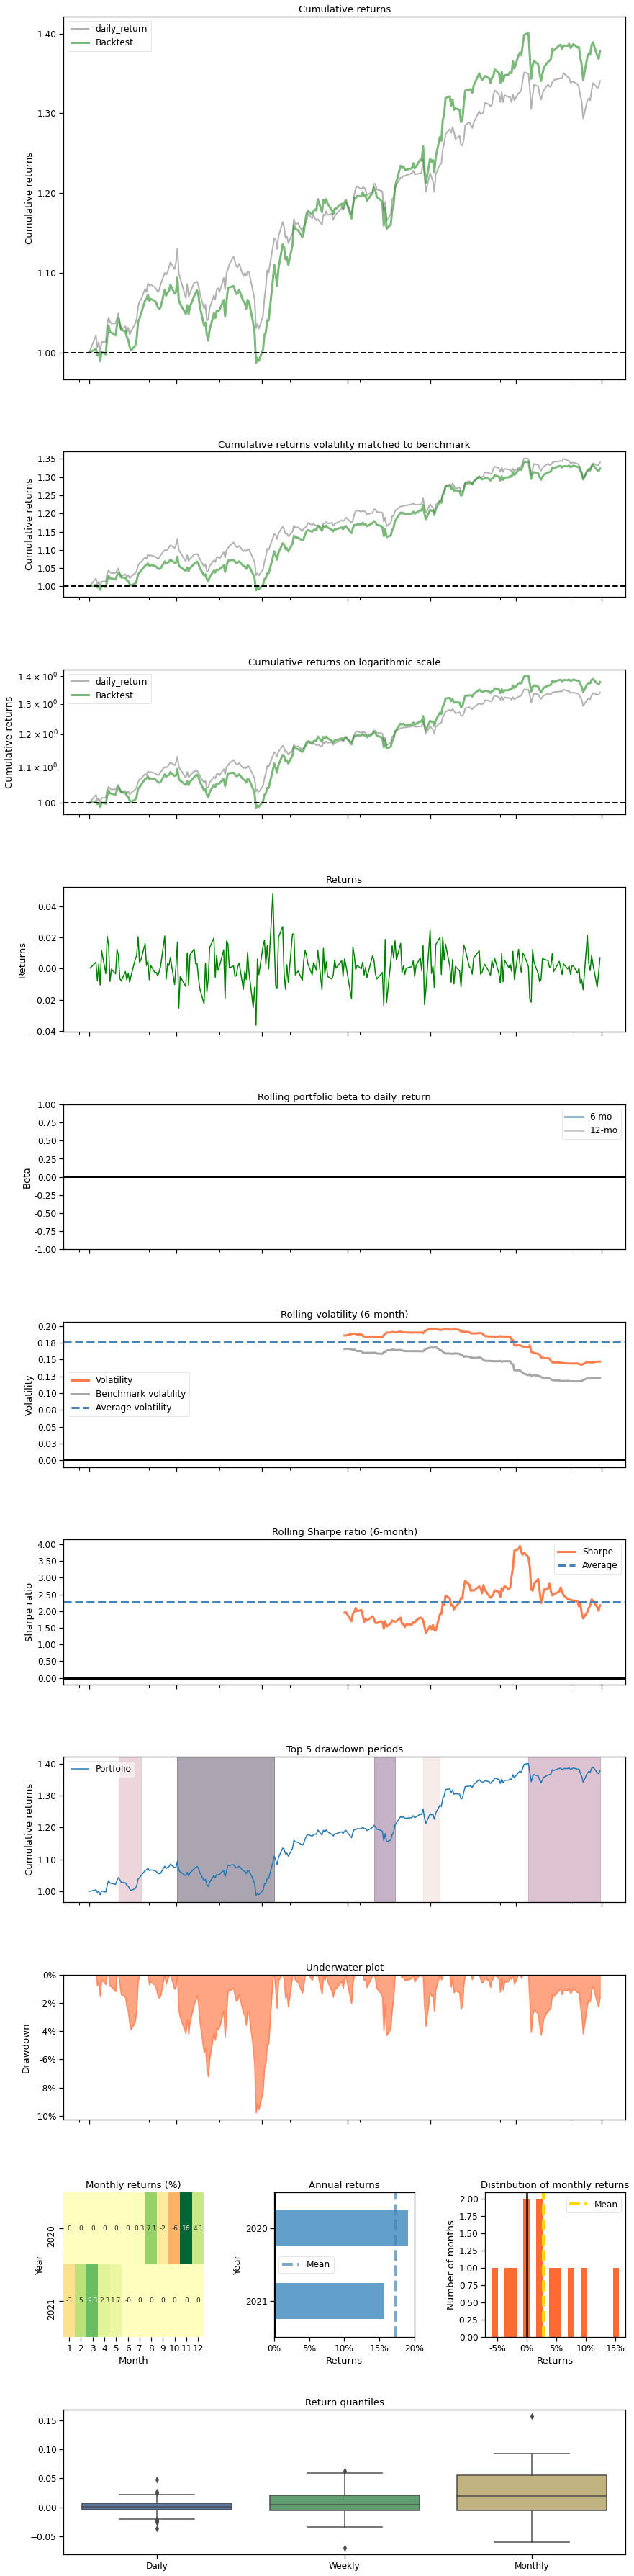

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

<a id='7'></a>
# RLlib Section

In [ ]:
ticker_list = config.DOW_30_TICKER
start_date = '2014-01-01'
end_date = '2021-08-05'


time_interval = '1D'

#if_vix = 'True'

TECHNICAL_INDICATORS_LIST = ['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']
technical_indicator_list = TECHNICAL_INDICATORS_LIST

## Download & Preprocess Data

In [ ]:
DP = DataProcessor('yahoofinance')
data = DP.download_data(ticker_list, start_date, end_date, time_interval)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
data = DP.clean_data(data)
data = DP.add_technical_indicator(data, technical_indicator_list)
data = DP.add_vix(data)


Clean data for AAPL
Data clean for AAPL is finished.
Clean data for AXP
Data clean for AXP is finished.
Clean data for BA
Data clean for BA is finished.
Clean data for CAT
Data clean for CAT is finished.
Clean data for CSCO
Data clean for CSCO is finished.
Clean data for CVX
Data clean for CVX is finished.
Clean data for DD
Data clean for DD is finished.
Clean data for DIS
Data clean for DIS is finished.
Clean data for GS
Data clean for GS is finished.
Clean data for HD
Data clean for HD is finished.
Clean data for IBM
Data clean for IBM is finished.
Clean data for INTC
Data clean for INTC is finished.
Clean data for JNJ
Data clean for JNJ is finished.
Clean data for JPM
Data clean for JPM is finished.
Clean data for KO
Data clean for KO is finished.
Clean data for MCD
Data clean for MCD is finished.
Clean data for MMM
Data clean for MMM is finished.
Clean data for MRK
Data clean for MRK is finished.
Clean data for MSFT
Data clean for MSFT is finished.
Clean data for NKE
Data clean for

In [ ]:
# start_date = '2014-01-01'
# end_date = '2020-07-30'
# time_interval = '1D'

# if_vix = 'True'
# TEST_START_DATE = '2020-08-01'
# TEST_END_DATE = '2021-08-05'

In [ ]:
train = data_split(data, '2014-01-01','2020-07-01',target_date_col = "time")
trade = data_split(data, '2020-07-01','2021-07-05',target_date_col = "time")


In [ ]:
price_array, tech_array, turbulence_array = DP.df_to_array(train, if_vix=True)


['AAPL' 'AXP' 'BA' 'CAT' 'CSCO' 'CVX' 'DD' 'DIS' 'GS' 'HD' 'IBM' 'INTC'
 'JNJ' 'JPM' 'KO' 'MCD' 'MMM' 'MRK' 'MSFT' 'NKE' 'PFE' 'PG' 'RTX' 'TRV'
 'UNH' 'V' 'VZ' 'WBA' 'WMT' 'XOM']
Successfully transformed into array


In [ ]:
price_array_test, tech_array_test, turbulence_array_test = DP.df_to_array(trade, if_vix=True)


['AAPL' 'AXP' 'BA' 'CAT' 'CSCO' 'CVX' 'DD' 'DIS' 'GS' 'HD' 'IBM' 'INTC'
 'JNJ' 'JPM' 'KO' 'MCD' 'MMM' 'MRK' 'MSFT' 'NKE' 'PFE' 'PG' 'RTX' 'TRV'
 'UNH' 'V' 'VZ' 'WBA' 'WMT' 'XOM']
Successfully transformed into array


## Load Environment

In [ ]:
import numpy as np
import os
import gym
from numpy import random as rd

class StockTradingEnv(gym.Env):

    def __init__(self, config, initial_account=1e6,
                 gamma=0.99, turbulence_thresh=90, min_stock_rate=0.1,
                 max_stock=1e2, initial_capital=1e6, buy_cost_pct=1e-3, 
                 sell_cost_pct=1e-3,reward_scaling=2 ** -11,  initial_stocks=None,
                 ):
        price_ary = config['price_array']
        tech_ary = config['tech_array']
        turbulence_ary = config['turbulence_array']
        if_train = config['if_train']
        n = price_ary.shape[0]
        self.price_ary =  price_ary.astype(np.float32)
        self.tech_ary = tech_ary.astype(np.float32)
        self.turbulence_ary = turbulence_ary
        
        self.tech_ary = self.tech_ary * 2 ** -7
        self.turbulence_bool = (turbulence_ary > turbulence_thresh).astype(np.float32)
        self.turbulence_ary = (self.sigmoid_sign(turbulence_ary, turbulence_thresh) * 2 ** -5).astype(np.float32)

        stock_dim = self.price_ary.shape[1]
        self.gamma = gamma
        self.max_stock = max_stock
        self.min_stock_rate = min_stock_rate
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.initial_capital = initial_capital
        self.initial_stocks = np.zeros(stock_dim, dtype=np.float32) if initial_stocks is None else initial_stocks

        # reset()
        self.day = None
        self.amount = None
        self.stocks = None
        self.total_asset = None
        self.gamma_reward = None
        self.initial_total_asset = None

        # environment information
        self.env_name = 'StockEnv'
        # self.state_dim = 1 + 2 + 2 * stock_dim + self.tech_ary.shape[1]
        # # amount + (turbulence, turbulence_bool) + (price, stock) * stock_dim + tech_dim
        self.state_dim = 1 + 2 + 3 * stock_dim + self.tech_ary.shape[1]
        # amount + (turbulence, turbulence_bool) + (price, stock) * stock_dim + tech_dim
        self.stocks_cd = None
        self.action_dim = stock_dim
        self.max_step = self.price_ary.shape[0] - 1
        self.if_train = if_train
        self.if_discrete = False
        self.target_return = 10.0
        self.episode_return = 0.0
        
        self.observation_space = gym.spaces.Box(low=-3000, high=3000, shape=(self.state_dim,), dtype=np.float32)
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(self.action_dim,), dtype=np.float32)
        
    def reset(self):
        self.day = 0
        price = self.price_ary[self.day]
        
        if self.if_train:
            self.stocks = (self.initial_stocks + rd.randint(0, 64, size=self.initial_stocks.shape)).astype(np.float32)
            self.stocks_cd = np.zeros_like(self.stocks)
            self.amount = self.initial_capital * rd.uniform(0.95, 1.05) - (self.stocks * price).sum()
        else:
            self.stocks = self.initial_stocks.astype(np.float32)
            self.stocks_cd = np.zeros_like(self.stocks)
            self.amount = self.initial_capital

        self.total_asset = self.amount + (self.stocks * price).sum()
        self.initial_total_asset = self.total_asset
        self.gamma_reward = 0.0
        return self.get_state(price)  # state

    def step(self, actions):
        actions = (actions * self.max_stock).astype(int)

        self.day += 1
        price = self.price_ary[self.day]
        self.stocks_cd += 1

        if self.turbulence_bool[self.day] == 0:
            min_action = int(self.max_stock * self.min_stock_rate)  # stock_cd
            for index in np.where(actions < -min_action)[0]:  # sell_index:
                if price[index] > 0:  # Sell only if current asset is > 0
                    sell_num_shares = min(self.stocks[index], -actions[index])
                    self.stocks[index] -= sell_num_shares
                    self.amount += price[index] * sell_num_shares * (1 - self.sell_cost_pct)
                    self.stocks_cd[index] = 0
            for index in np.where(actions > min_action)[0]:  # buy_index:
                if price[index] > 0:  # Buy only if the price is > 0 (no missing data in this particular date)
                    buy_num_shares = min(self.amount // price[index], actions[index])
                    self.stocks[index] += buy_num_shares
                    self.amount -= price[index] * buy_num_shares * (1 + self.buy_cost_pct)
                    self.stocks_cd[index] = 0

        else:  # sell all when turbulence
            self.amount += (self.stocks * price).sum() * (1 - self.sell_cost_pct)
            self.stocks[:] = 0
            self.stocks_cd[:] = 0

        state = self.get_state(price)
        total_asset = self.amount + (self.stocks * price).sum()
        reward = (total_asset - self.total_asset) * self.reward_scaling
        self.total_asset = total_asset

        self.gamma_reward = self.gamma_reward * self.gamma + reward
        done = self.day == self.max_step
        if done:
            reward = self.gamma_reward
            self.episode_return = total_asset / self.initial_total_asset

        return state, reward, done, dict()

    def get_state(self, price):
        amount = np.array(max(self.amount, 1e4) * (2 ** -12), dtype=np.float32)
        scale = np.array(2 ** -6, dtype=np.float32)
        return np.hstack((amount,
                          self.turbulence_ary[self.day],
                          self.turbulence_bool[self.day],
                          price * scale,
                          self.stocks * scale,
                          self.stocks_cd,
                          self.tech_ary[self.day],
                          ))  # state.astype(np.float32)
    
    @staticmethod
    def sigmoid_sign(ary, thresh):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x * np.e)) - 0.5

        return sigmoid(ary / thresh) * thresh


In [ ]:
env = StockTradingEnv

## Training

In [ ]:
agent_rllib = DRLAgent_rllib(env = env,
                       price_array=price_array,
                       tech_array=tech_array,
                       turbulence_array=turbulence_array)

In [ ]:
model_ppo,model_config_ppo = agent_rllib.get_model("ppo")

In [ ]:
#model_config_ppo

In [ ]:
#ray.shutdown()
trained_ppo = agent_rllib.train_model(model=model_ppo, 
                                model_name='ppo',
                                model_config=model_config_ppo,
                                total_episodes=100)


2021-08-29 14:32:09,487	INFO services.py:1265 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-29 14:32:22,479	INFO trainable.py:109 -- Trainable.setup took 10.532 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2021-08-29 14:32:30,241	WARNING deprecation.py:39 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


## Testing

In [ ]:
#ray.shutdown()
rllib_account_value = agent_rllib.DRL_prediction(model = model_ppo,
                                                model_name='ppo', 
                                                env = env,
                                                price_array = price_array_test, 
                                                tech_array = tech_array_test, 
                                                turbulence_array = turbulence_array_test, 
                                                agent_path='./test_ppo/checkpoint_000100/checkpoint-100'
                                                )

2021-08-29 15:04:59,697	INFO services.py:1265 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-29 15:05:17,485	INFO trainable.py:109 -- Trainable.setup took 20.357 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2021-08-29 15:05:17,661	INFO trainable.py:383 -- Restored on 172.28.0.2 from checkpoint: ./test_ppo/checkpoint_000100/checkpoint-100
2021-08-29 15:05:17,682	INFO trainable.py:390 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 1761.3775839805603, '_episodes_total': 244}


Restoring from checkpoint path ./test_ppo/checkpoint_000100/checkpoint-100
episode return: 1.4309360666549649
Test Finished!


## Backtesting

In [ ]:
baseline_df =  DataProcessor('yahoofinance').download_data(ticker_list = ["^DJI"], 
                                                            start_date = '2020-07-01', 
                                                            end_date = '2021-07-05', 
                                                            time_interval = "1D")
stats = backtest_stats(baseline_df, value_col_name = 'close')


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (254, 9)
Annual return          0.348511
Cumulative returns     0.351715
Annual volatility      0.145303
Sharpe ratio           2.139596
Calmar ratio           3.902364
Stability              0.946267
Max drawdown          -0.089308
Omega ratio            1.427764
Sortino ratio          3.204934
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.082606
Daily value at risk   -0.017073
dtype: float64


In [ ]:
baseline_df.shape

(254, 9)

In [ ]:
len(rllib_account_value)

254

In [ ]:
rllib_account_value = pd.DataFrame({'date':baseline_df.date,'account_value':rllib_account_value})

In [ ]:
rllib_account_value.tail()

,date,account_value
249,2021-06-28,1.419389e+06
250,2021-06-29,1.412318e+06
251,2021-06-30,1.420046e+06
252,2021-07-01,1.427840e+06
253,2021-07-02,1.430936e+06


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=rllib_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.426904
Cumulative returns     0.430936
Annual volatility      0.196885
Sharpe ratio           1.911338
Calmar ratio           4.106032
Stability              0.911279
Max drawdown          -0.103970
Omega ratio            1.413767
Sortino ratio          3.203338
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.146177
Daily value at risk   -0.023312
dtype: float64


In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline

# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(rllib_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = rllib_account_value.loc[0,'date'],
             baseline_end = rllib_account_value.loc[len(rllib_account_value)-1,'date'])
plt.savefig('backtesting_rllib.png')


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


<Figure size 1008x5184 with 13 Axes>
